In [1]:
#functions to access twitter
#https://galeascience.wordpress.com/2016/03/18/collecting-twitter-data-with-python/


Report:
Using the tweepy library for the Twitter API, I returned tweets with the search criteria "Jeff Sessions." This particularly search criteria was chosen because Jeff Sessions had just rescinded the federal government's non-interference policy on cannabis. I created a dataframe that included number of retweets and text field. By limiting the text field to the first two letters, I identified if a tweet was a retweet (ie. identified as "rt" in the text). Using this output, I plotted the frequency of retweets for a given tweet based on whether the tweet was original (written by the author) or a retweet in itself. The resulting plot suggests that the vast majority of tweets on (at least) this inflammatory, current issue are not based on the original thoughts of twitter users but rather just mass propagation a relatively few number of original sources.



In [120]:
import tweepy
from tweepy import OAuthHandler
import json
import datetime as dt
import time
import os
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
def load_api():
    ''' Function that loads the twitter API after authorizing the user. '''

    consumer_key = 'ck09dmzDGkkvZU6FJQg62TVpK'
    consumer_secret = 'Iz9Ale7j95BBVXxm9PYxLoEt0jFEL48f8qQInOS6zXqvrvqL2Y'
    access_token = '2413257762-Nfk1TOYJw9xHqvXXX2c24R85yAj92JeJkD5RGpP'
    access_secret = '1UdjfMMg1H54IUERV6cRrVzyE0XTDgVtQKc003oPnObM0'
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    # load the twitter API via tweepy
    return tweepy.API(auth)

In [4]:
def tweet_search(api, query, max_tweets, max_id, since_id):
    ''' Function that takes in a search string 'query', the maximum
        number of tweets 'max_tweets', and the minimum (i.e., starting)
        tweet id. It returns a list of tweepy.models.Status objects. '''

    searched_tweets = []
    while len(searched_tweets) < max_tweets:
        remaining_tweets = max_tweets - len(searched_tweets)
        try:
            new_tweets = api.search(q=query, count=remaining_tweets,
                                    since_id=str(since_id),
                                    max_id=str(max_id-1))
#                                    geocode=geocode)
            print('found',len(new_tweets),'tweets')
            if not new_tweets:
                print('no tweets found')
                break
            searched_tweets.extend(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError:
            print('exception raised, waiting 15 minutes')
            print('(until:', dt.datetime.now()+dt.timedelta(minutes=15), ')')
            time.sleep(15*60)
            break # stop the loop
    return searched_tweets, max_id


In [5]:
def get_tweet_id(api, date='', days_ago=9, query='a'):
    ''' Function that gets the ID of a tweet. This ID can then be
        used as a 'starting point' from which to search. The query is
        required and has been set to a commonly used word by default.
        The variable 'days_ago' has been initialized to the maximum
        amount we are able to search back in time (9).'''

    if date:
        # return an ID from the start of the given day
        td = date + dt.timedelta(days=1)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        tweet = api.search(q=query, count=1, until=tweet_date)
    else:
        # return an ID from __ days ago
        td = dt.datetime.now() - dt.timedelta(days=days_ago)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        # get list of up to 10 tweets
        tweet = api.search(q=query, count=10, until=tweet_date)
        print('search limit (start/stop):',tweet[0].created_at)
        # return the id of the first tweet in the list
        return tweet[0].id

In [6]:
def write_tweets(tweets, filename):
    ''' Function that appends tweets to a file. '''

    with open(filename, 'a') as f:
        for tweet in tweets:
            json.dump(tweet._json, f)
            f.write('\n')


In [7]:
def main():
    ''' This is a script that continuously searches for tweets
        that were created over a given number of days. The search
        dates and search phrase can be changed below. '''



    ''' search variables: '''
    search_phrases = ['Jeff Sessions']#WithEnoughCoffeeICan','#coffee']
    time_limit = 24                           # runtime limit in hours
    max_tweets = 100                           # number of tweets per search (will be
                                               # iterated over) - maximum is 100
    min_days_old, max_days_old = 1, 2          # search limits e.g., from 7 to 8
                                               # gives current weekday from last week,
                                               # min_days_old=0 will search from right now
    #USA = '39.8,-95.583068847656,2500km'       # this geocode includes nearly all American
                                               # states (and a large portion of Canada)


    # loop over search items,
    # creating a new file for each
    for search_phrase in search_phrases:

        print('Search phrase =', search_phrase)

        ''' other variables '''
        name = search_phrase.split()[0]
        json_file_root = name + '/'  + name
        os.makedirs(os.path.dirname(json_file_root), exist_ok=True)
        read_IDs = False

        # open a file in which to store the tweets
        if max_days_old - min_days_old == 1:
            d = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}'.format(d.year, d.month, d.day)
        else:
            d1 = dt.datetime.now() - dt.timedelta(days=max_days_old-1)
            d2 = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}_to_{3}-{4:0>2}-{5:0>2}'.format(
                  d1.year, d1.month, d1.day, d2.year, d2.month, d2.day)
        json_file = json_file_root + '_' + day + '.json'
        if os.path.isfile(json_file):
            print('Appending tweets to file named: ',json_file)
            read_IDs = True

        # authorize and load the twitter API
        api = load_api()

        # set the 'starting point' ID for tweet collection
        if read_IDs:
            # open the json file and get the latest tweet ID
            with open(json_file, 'r') as f:
                lines = f.readlines()
                max_id = json.loads(lines[-1])['id']
                print('Searching from the bottom ID in file')
        else:
            # get the ID of a tweet that is min_days_old
            if min_days_old == 0:
                max_id = -1
            else:
                max_id = get_tweet_id(api, days_ago=(min_days_old-1))
        # set the smallest ID to search for
        since_id = get_tweet_id(api, days_ago=(max_days_old-1))
        print('max id (starting point) =', max_id)
        print('since id (ending point) =', since_id)



        ''' tweet gathering loop  '''
        start = dt.datetime.now()
        end = start + dt.timedelta(hours=time_limit)
        count, exitcount = 0, 0
        while dt.datetime.now() < end:
            count += 1
            print('count =',count)
            # collect tweets and update max_id
            tweets, max_id = tweet_search(api, search_phrase, max_tweets,
                                          max_id=max_id, since_id=since_id)
                                          #geocode=USA)
            # write tweets to file in JSON format
            if tweets:
                write_tweets(tweets, json_file)
                exitcount = 0
            else:
                exitcount += 1
                if exitcount == 3:
                    if search_phrase == search_phrases[-1]:
                        sys.exit('Maximum number of empty tweet strings reached - exiting')
                    else:
                        print('Maximum number of empty tweet strings reached - breaking')
                        break





In [8]:
if __name__ == "__main__":
    main()

Search phrase = Jeff Sessions
Appending tweets to file named:  Jeff/Jeff_2018-01-03.json
Searching from the bottom ID in file
search limit (start/stop): 2018-01-02 23:59:59
max id (starting point) = 948671694478049280
since id (ending point) = 948343145875558401
count = 1
found 100 tweets
count = 2
found 100 tweets


PermissionError: [Errno 13] Permission denied: 'Jeff/Jeff_2018-01-03.json'

In [85]:
# read the json files
#tweet_files = ['NationalCoffeeDay_testsample.json, 'file_2.json', ...]
tweet_files = ['Jeff_2018-01-03.json']
tweets = []
for file in tweet_files:
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))

In [86]:
print(json.dumps('Jeff_2018-01-03.json', indent=1))

"Jeff_2018-01-03.json"


In [87]:
def populate_tweet_df(tweets):
    df_Sessions = pd.DataFrame()
 
    df_Sessions['text'] = list(map(lambda tweet: tweet['text'], tweets))
 
    df_Sessions['location'] = list(map(lambda tweet: tweet['user']['location'], tweets))
 
    df_Sessions['country_code'] = list(map(lambda tweet: tweet['place']['country_code']
                                  if tweet['place'] != None else '', tweets))
 
    df_Sessions['long'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][0]
                        if tweet['coordinates'] != None else 'NaN', tweets))
 
    df_Sessions['latt'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][1]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    df_Sessions['user'] = list(map(lambda tweet: tweet['user']['name'], tweets))
    df_Sessions['source'] = list(map(lambda tweet: tweet['source'], tweets))
    df_Sessions['user_description'] = list(map(lambda tweet: tweet['user']['description'], tweets))
    df_Sessions['user_mentions'] = list(map(lambda tweet: tweet['entities']['user_mentions'], tweets))
    df_Sessions['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets))
 
    return df_Sessions

In [88]:
df_Sessions = populate_tweet_df(tweets)
df_Sessions = df_Sessions.drop(['source','user_mentions','user'],axis=1)

In [89]:
df_Sessions.head(n=10)

,text,location,country_code,long,latt,user_description,retweet_count
0,Eric Holder ‘Disturbed’ By Sessions’ Silence I...,"Colonie, NY",,NaN,NaN,"Attorney, Dad, Environmentalist, Hiker, Reader...",0
1,RT @deenie7940: Jeff Sessions’ Marijuana Advis...,,,NaN,NaN,NO LISTS I BLOCK. DJ #Trump all the way. #Depl...,1
2,"RT @AriBerman: Doug Jones, who prosecuted KKK ...",,,NaN,NaN,your local heathen // proud millennial,1335
3,RT @GeorgiaDirtRoad: Burning evidence this tim...,,,NaN,NaN,,853
4,RT @nowthisnews: Jeff Sessions' 'marijuana adv...,,,NaN,NaN,,87
5,RT @NatashaBertrand: Geoffrey Berman has been ...,"Manhattan, NY",,NaN,NaN,,208
6,RT @thedailybeast: Jeff Sessions' marijuana ad...,Everywhere,,NaN,NaN,,83
7,RT @GeorgiaDirtRoad: Burning evidence this tim...,"North Carolina, USA",,NaN,NaN,Street - smart country boy. Your hurt feelin...,853
8,RT @GeorgiaDirtRoad: The Obama Administration ...,"Oregon, USA",,NaN,NaN,Born again Christian.,9760
9,@stacy_redvirgo @Trumperland @StorminSuzi DJTs...,"Missouri, USA",,NaN,NaN,Fly over Deplorable PotAholic is POKER nickna...,0


In [90]:
def text_cleaner(text):    
     # Visual inspection identifies a form of punctuation spaCy does not
    # remove parentheses
    text = re.sub("[\(|\)]", "", text)
    text = re.sub("[@]", "", text)
    # remove non-ascii characters
    text = re.sub(r'[^\x00-\x7F]','', text)
    # remove single character words
    #text = re.sub(r"\b[a-zA-Z]\b", "", text)
    # remove double hyphen
    text = re.sub(r'--','-',text)
    # regular expression that replaces brackets and anything between them with nothing
#     text = re.sub("[\[].*?[\]]", "", text)
#     text = ' '.join(text.split())
    return text
    

In [91]:
# clean up the text 
for index, row in df_Sessions.iterrows():
        i = row['text'].lower()
        j = row['user_description'].lower()
        i = text_cleaner(i)
        j= text_cleaner(j)
        df_Sessions.loc[index, "text"] = i
        df_Sessions.loc[index, "user_description"] = j

In [92]:
df_Sessions.head()

,text,location,country_code,long,latt,user_description,retweet_count
0,eric holder disturbed by sessions silence in t...,"Colonie, NY",,NaN,NaN,"attorney, dad, environmentalist, hiker, reader...",0
1,rt deenie7940: jeff sessions marijuana adviser...,,,NaN,NaN,no lists i block. dj #trump all the way. #depl...,1
2,"rt ariberman: doug jones, who prosecuted kkk k...",,,NaN,NaN,your local heathen // proud millennial,1335
3,rt georgiadirtroad: burning evidence this time...,,,NaN,NaN,,853
4,rt nowthisnews: jeff sessions' 'marijuana advi...,,,NaN,NaN,,87


In [117]:
#capture the first 2 letters in tweet to see if it is a retweet
for row in df_Sessions:
    df_Sessions['rt'] = df_Sessions['text'].str[0:2]
df_Sessions.head(n=20)

#create a binary feature for retweet
df_Sessions['retweet?'] = np.where(df_Sessions['rt'] == 'rt',1,0)

df_Sessions.head(n=5)

,text,location,country_code,long,latt,user_description,retweet_count,rt,retweet?
0,eric holder disturbed by sessions silence in t...,"Colonie, NY",,NaN,NaN,"attorney, dad, environmentalist, hiker, reader...",0,er,0
1,rt deenie7940: jeff sessions marijuana adviser...,,,NaN,NaN,no lists i block. dj #trump all the way. #depl...,1,rt,1
2,"rt ariberman: doug jones, who prosecuted kkk k...",,,NaN,NaN,your local heathen // proud millennial,1335,rt,1
3,rt georgiadirtroad: burning evidence this time...,,,NaN,NaN,,853,rt,1
4,rt nowthisnews: jeff sessions' 'marijuana advi...,,,NaN,NaN,,87,rt,1


In [118]:

df_Sessions = df_Sessions.drop(['latt','long','country_code','rt'],axis=1)

In [119]:
df_Sessions.head()

,text,location,user_description,retweet_count,retweet?
0,eric holder disturbed by sessions silence in t...,"Colonie, NY","attorney, dad, environmentalist, hiker, reader...",0,0
1,rt deenie7940: jeff sessions marijuana adviser...,,no lists i block. dj #trump all the way. #depl...,1,1
2,"rt ariberman: doug jones, who prosecuted kkk k...",,your local heathen // proud millennial,1335,1
3,rt georgiadirtroad: burning evidence this time...,,,853,1
4,rt nowthisnews: jeff sessions' 'marijuana advi...,,,87,1


C:\Users\stace\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


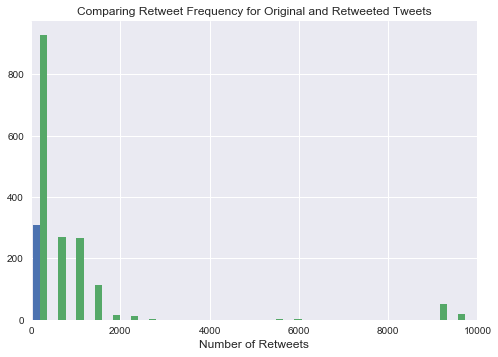

In [158]:
retweet_0 = df_Sessions.ix[(df_Sessions['retweet?'] == 0)] 
retweet_1 = df_Sessions.ix[(df_Sessions['retweet?'] == 1)]

# #plot retweet count distribution given for tweets that are themselves original or retweets
ax=plt.subplot(111)
bins = np.linspace(0,100,10000)
ax.set_title("Comparing Retweet Frequency for Original and Retweeted Tweets", fontsize='12')
ax.set_xlabel("Number of Retweets", fontsize='12')
ax.set_xlim((0, 10000))
# ax.set_ylabel("# of Countries")
plt.hist([retweet_0['retweet_count'],retweet_1['retweet_count']],bins=200)
plt.legend()

plt.show()

In [145]:
# tokenize the text
nlp = spacy.load('en')
df_Sessions['text_tokenized'] = df_Sessions['text'].apply(lambda x: nlp(x))
df_Sessions['user_description'] = df_Sessions['user_description'].apply(lambda x: nlp(x))


In [62]:
# Utility function to create a list of the 1000 most common words. 

def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(20)]



In [63]:
# return most common words for writers

common_words_text = []
for i, row in df_Sessions.iterrows():
    baggedwords_text = bag_of_words(row['text_tokenized'])
    common_words_text.append(baggedwords_text)



# common_words_user = []    
# for i, row in df_Sessions.iterrows():
#     baggedwords_user = bag_of_words(row['user_description'])
#     common_words_user.append(baggedwords_user)

flat_list_text=[]
for sublist in common_words_text:
    for item in sublist:
        flat_list_text.append(item)
        
# flat_list_user=[]
# for sublist in common_words_user:
#     for item in sublist:
#         flat_list_user.append(item)
        

words_in_text = set(flat_list_text)
# words_in_user_description = set(flat_list_user)
# print(words_in_articles)
# print(len(words_in_articles))

In [64]:
# print(words_in_user_description)
print(words_in_text)

{'accuse', 'https://t.co/vzqdylvn7p', 'noon', 'unload', 'lopez', '@peterluisvenero', 'https://t.co/56ixjciufj', 'https://t.co/odwfjrdwjp', 'opportunist', 'district', 'smoke', 'merry', 'opposed', 'financial', 'appoints', 'kid', 'dnc', 'https://t.co/nsit8nq8fi', 'luther', '@kylegriffin1', 'stand', 'traffic', 'cry', 'stoner', 'ongoing', 'vacate', 'https://t.co/vjdz2zoll6', 'nicola', 'anarchronism', 't.', 'close', 'document', 'ppl', 'https://t.co/hsg5cdsjwy', 'private', 'man', 'legalized', 'https://t.co/ztobaebtjd', 'role', '@calvinstowell', 'like', 'amateur', 'https://t.co/h6fuszdlna', 'worthless', 'https://t.co/2ijohwmfke', '@bbusa617', 'https://t.co/jfbvhhd7v7', 'bong', 'payscale', 'boo', 'days', 'https://t.co/2yzagxycrk', 'https://t.co/xtfuiknord', '@adjustedwell', '@brookem_feldman', 'https://t.co/tmsomhuxh6', 'mole', 'firm', 'ya', 'https://t.co/o9frbplhgc', 'late', 'jihad', 'xx', 'https://t.co/fdqkkywjem', 'lin', 'important', 'totally', '@trumpsdc', 'think', 'slap', 'entire', '@lamoo

In [65]:
for word in words_in_text:
    print('%s : %d' % (word, words_in_text[word]))

TypeError: 'set' object is not subscriptable